<a href="https://colab.research.google.com/github/gyselle-marques/ReconhecimentoFacial-DesafioDIO/blob/main/reconhecimento_facial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install opencv-python ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 914.6/914.6 kB 13.2 MB/s eta 0:00:00


In [2]:
from ultralytics import YOLO

# Carregar o modelo YOLO pré-treinado
model = YOLO("yolo11n.pt")  # ou o caminho para o seu modelo treinado

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 5.35M/5.35M [00:00<00:00, 65.1MB/s]


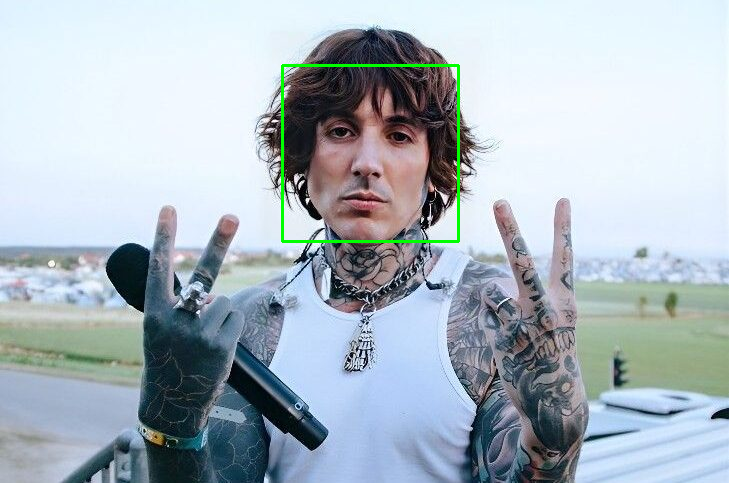

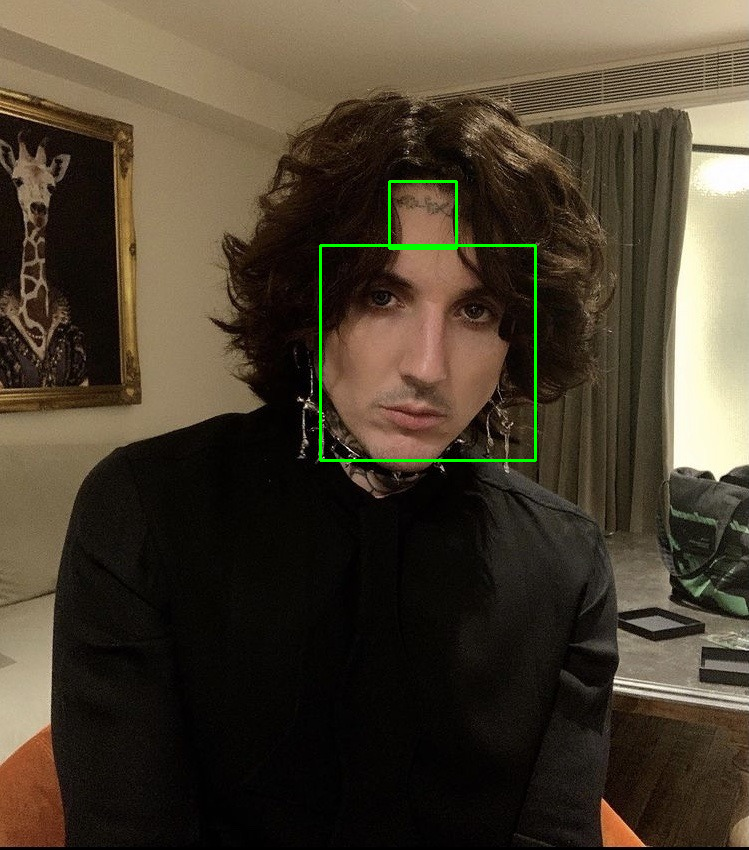

Imagem da URL salva como faces_detectadas_url.jpg
Imagem local salva como faces_detectadas_local.jpg


In [4]:
import cv2
from ultralytics import YOLO
import numpy as np
import requests
from google.colab.patches import cv2_imshow

def detectar_faces(image_path_or_url):
    try:
        if image_path_or_url.startswith("http://") or image_path_or_url.startswith("https://"):
            response = requests.get(image_path_or_url, stream=True)
            response.raise_for_status()
            image_array = np.asarray(bytearray(response.content), dtype=np.uint8)
            image = cv2.imdecode(image_array, cv2.IMREAD_COLOR)
            if image is None:
                raise ValueError("Não foi possível decodificar a imagem da URL.")
        else:
            image = cv2.imread(image_path_or_url)
            if image is None:
                raise FileNotFoundError(f"Imagem não encontrada em: {image_path_or_url}")

        # Carregar o modelo de detecção de faces pré-treinado
        face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

        # Converter a imagem para escala de cinza
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Detectar faces
        faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

        # Desenhar retângulos ao redor das faces
        for (x, y, w, h) in faces:
            cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 2)

        # Exibir a imagem com as detecções
        cv2_imshow(image)
        return image

    except requests.exceptions.RequestException as e:
        print(f"Erro ao baixar a imagem da URL: {e}")
    except FileNotFoundError as e:
        print(f"Erro ao carregar a imagem local: {e}")
    except ValueError as e:
        print(f"Erro na imagem: {e}")
    except Exception as e:
        print(f"Um erro ocorreu: {e}")
    return None


# Exemplos de uso:
url_imagem = "https://confererock.com.br/wp-content/uploads/2024/12/olliver-sykes.jpg"
imagem_processada_url = detectar_faces(url_imagem)

imagem_local_path = "photo.jpg"
imagem_processada_local = detectar_faces(imagem_local_path)

if imagem_processada_url is not None:
    cv2.imwrite("faces_detectadas_url.jpg", imagem_processada_url)
    print("Imagem da URL salva como faces_detectadas_url.jpg")

if imagem_processada_local is not None:
    cv2.imwrite("faces_detectadas_local.jpg", imagem_processada_local)
    print("Imagem local salva como faces_detectadas_local.jpg")

In [5]:
!pip install face_recognition

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.1/100.1 MB 11.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 70.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for dlib: filename=dlib-19.24.6-cp311-cp311-linux_x86_64.whl size=4100410 sha256=d2f8820333e44bbfd3ce9de5903f5a855f920a9287b9a0ea306a4ad4b1c87170
  Stored in directory: /root/.cache/pip/wheels/fe/c7/1f/c778b9f7cc6d8d0da4f6697f619f9eb5a49d54d2a2c8267f3c
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566162 sha256=4f03959a7f48a33f096f2e239b7ce3df10713e845dad4ec6d218653ca891d7ed
  Stored in directory: /root/.cache/pip/wheels/04/52/ec/9355da79c29f160b038a20c784db2803c2f9fa2c8a462c176a
Successfully built dlib face-recognition-models


In [6]:
from google.colab import drive
drive.mount('/content/drive')
# Depois use o caminho: '/content/drive/My Drive/pasta/sua_imagem.jpg'

Mounted at /content/drive


In [7]:
def detectar_faces_e_classificar(image_path, encodings, tolerance=0.7):
    """
    Detecta faces e classifica pessoas.

    Args:
        image_path (str): Caminho da imagem.
        encodings (dict): Encodings de faces.
        tolerance (float): Tolerância para reconhecimento (opcional).

    Returns:
        imagem: Imagem com faces classificadas.
    """

    try:
        # Carregar imagem
        image = cv2.imread(image_path)
        if image is None:
            raise FileNotFoundError(f"Imagem não encontrada em: {image_path}")

        # Converter para RGB
        rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Detectar faces
        face_locations = face_recognition.face_locations(rgb_image, model="cnn")  # Modelo mais preciso
        face_encodings = face_recognition.face_encodings(rgb_image, face_locations)

        nomes_identificados = []

        for (top, right, bottom, left), face_encoding in zip(face_locations, face_encodings):
            # Comparar face detectada com encodings
            matches = face_recognition.compare_faces(list(encodings.values()), face_encoding, tolerance=tolerance)

            # Mostrar nomes das faces comparadas
            print(f"Encodings comparados: {list(encodings.keys())}")

            name = "Desconhecido"

            if True in matches:
                # Index da primeira correspondência
                first_match_index = matches.index(True)
                name = list(encodings.keys())[first_match_index]
                print(f"Face reconhecida como: {name}")
            else:
                print("Nenhuma correspondência encontrada")

            # Desenhar retângulo e nome
            cv2.rectangle(image, (left, top), (right, bottom), (0, 255, 0), 2)
            cv2.putText(image, name, (left, top - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
            nomes_identificados.append(name)

        # Exibir imagem classificada
        cv2_imshow(image)
        return image

    except FileNotFoundError as e:
        logging.error(f"Erro ao carregar imagem: {e}")
    except Exception as e:
        logging.error(f"Erro ocorreu: {e}")
    return None

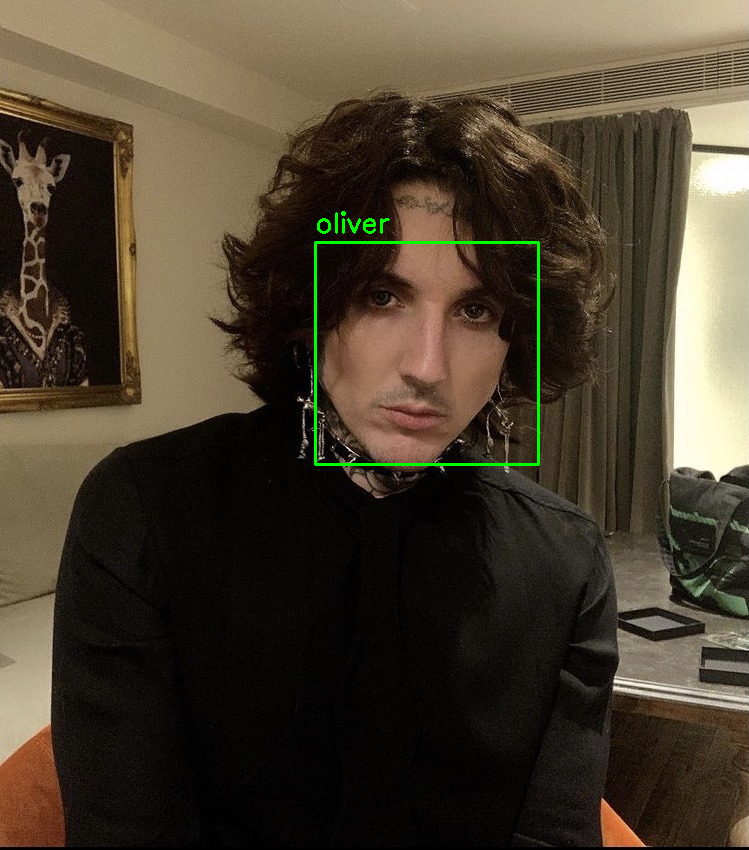

In [9]:
import cv2
import face_recognition
import numpy as np
from google.colab.patches import cv2_imshow
import os
from multiprocessing import Pool
import logging

# Configuração de logging
logging.basicConfig(level=logging.INFO)

def carregar_encodings(diretorio_imagens):
    """
    Carrega encodings de faces de personagens.

    Args:
        diretorio_imagens (str): Caminho do diretório onde as imagens estão armazenadas.

    Returns:
        dict: Dicionário contendo os encodings das faces associadas aos nomes dos personagens.
    """
    encodings = {}  # Dicionário para armazenar os encodings de cada face
    # Itera sobre os arquivos no diretório de imagens
    for nome_arquivo in os.listdir(diretorio_imagens):
        # Filtra apenas arquivos de imagem com extensões .jpg ou .png
        if nome_arquivo.endswith(".jpg") or nome_arquivo.endswith(".png"):
            imagem_path = os.path.join(diretorio_imagens, nome_arquivo)
            # Carrega a imagem usando face_recognition
            imagem = face_recognition.load_image_file(imagem_path)
            # Gera os encodings da face presente na imagem
            encodings_face = face_recognition.face_encodings(imagem)

            # Verifica se algum encoding foi encontrado
            if len(encodings_face) > 0:
                encoding = encodings_face[0]  # Considera o primeiro encoding
                nome_personagem = nome_arquivo.split('.')[0]  # Extrai o nome do personagem
                encodings[nome_personagem] = encoding  # Armazena o encoding associado ao nome do personagem
            else:
                logging.warning(f"Nenhuma face detectada na imagem {nome_arquivo}")

    return encodings  # Retorna o dicionário de encodings

def detectar_faces_e_classificar(image_path, encodings, tolerance=0.7):
    """
    Detecta faces em uma imagem e tenta classificá-las usando os encodings de personagens fornecidos.

    Args:
        image_path (str): Caminho para a imagem a ser analisada.
        encodings (dict): Dicionário contendo os encodings das faces dos personagens.
        tolerance (float): Tolerância para o reconhecimento das faces. Valores maiores permitem mais variações na comparação.

    Returns:
        imagem: A imagem com as faces detectadas e classificadas (com retângulos e nomes).
    """
    try:
        # Carrega a imagem da localização fornecida
        imagem = cv2.imread(image_path)
        if imagem is None:
            raise FileNotFoundError(f"Imagem não encontrada em: {image_path}")

        # Converte a imagem de BGR (padrão do OpenCV) para RGB, que é o formato esperado pelo face_recognition
        rgb_image = cv2.cvtColor(imagem, cv2.COLOR_BGR2RGB)
        # Detecta as localizações das faces na imagem
        face_locations = face_recognition.face_locations(rgb_image)
        # Extrai os encodings das faces detectadas
        face_encodings = face_recognition.face_encodings(rgb_image, face_locations)

        nomes_identificados = []  # Lista para armazenar os nomes dos personagens identificados
        # Para cada face detectada, verifica se corresponde a algum personagem
        for (top, right, bottom, left), face_encoding in zip(face_locations, face_encodings):
            # Compara a face detectada com os encodings conhecidos
            matches = face_recognition.compare_faces(list(encodings.values()), face_encoding, tolerance=tolerance)
            name = "Desconhecido"  # Valor padrão para faces não reconhecidas

            # Se houver uma correspondência, obtém o nome do personagem
            if True in matches:
                first_match_index = matches.index(True)  # Índice da primeira correspondência
                name = list(encodings.keys())[first_match_index]  # Nome do personagem correspondente

            # Desenha um retângulo ao redor da face e exibe o nome do personagem
            cv2.rectangle(imagem, (left, top), (right, bottom), (0, 255, 0), 2)
            cv2.putText(imagem, name, (left, top - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
            nomes_identificados.append(name)  # Adiciona o nome identificado à lista

        # Exibe a imagem com as faces identificadas
        cv2_imshow(imagem)
        return imagem  # Retorna a imagem com as faces detectadas e classificadas

    except FileNotFoundError as e:
        logging.error(f"Erro ao carregar a imagem: {e}")  # Loga um erro se a imagem não for encontrada
    except Exception as e:
        logging.error(f"Um erro ocorreu: {e}")  # Loga erros genéricos
    return None  # Retorna None caso haja algum erro

def main():
    """
    Função principal para carregar encodings e detectar/classificar faces em uma imagem.
    """
    # Diretório contendo as imagens dos personagens
    diretorio_imagens = "/content/drive/MyDrive/Reconhecimento_face"
    # Caminho da imagem a ser analisada
    imagem_com_todos = "/content/drive/MyDrive/Reconhecimento_face/imagem_analisada/photo.jpg"

    # Carrega os encodings das faces dos personagens a partir das imagens
    encodings_personagens = carregar_encodings(diretorio_imagens)
    # Detecta e classifica as faces na imagem fornecida
    imagem_com_nomes = detectar_faces_e_classificar(imagem_com_todos, encodings_personagens)

    # Se a imagem foi processada com sucesso, salva a imagem resultante com os nomes das faces
    if imagem_com_nomes is not None:
        nome_arquivo_saida = "/content/drive/MyDrive/Reconhecimento_face/face.png"
        cv2.imwrite(nome_arquivo_saida, imagem_com_nomes)  # Salva a imagem com os nomes identificados
        logging.info(f"Imagem com os nomes salva como {nome_arquivo_saida}")  # Loga sucesso

if __name__ == "__main__":
    main()  # Chama a função principal para iniciar o processo
